In [1]:
!pip install d2l==0.17.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [3]:
# 生成数据集，将带有噪声的线性模型构成成一个人造数据集 
def synthetic_data(w, b, num_examples):
  """生成 y = Xw + b + 噪声"""
  X = torch.normal(0, 1, (num_examples, len(w)))
  y = torch.matmul(X, w) + b
  y += torch.normal(0, 1, y.shape)
  return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.7975, -0.0895]) 
label: tensor([1.2624])


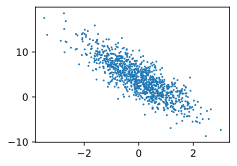

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

In [6]:
# 读取数据集
def data_iter(batch_size, features, labels):
  num_examples = len(features)
  indices = list(range(num_examples))
  # 这些样本是随机读取的，没有特定的顺序
  random.shuffle(indices)
  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(
        indices[i: min(i + batch_size, num_examples)]
    )
    yield features[batch_indices], labels[batch_indices]

In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
  print(X, '\n', y)
  break

tensor([[-1.1926, -1.4059],
        [ 0.3388, -0.7411],
        [ 1.4395, -1.1267],
        [-0.8726,  1.0604],
        [ 0.1319,  0.4138],
        [ 0.5796, -0.5140],
        [-1.2099, -0.0266],
        [-2.2344, -1.5482],
        [-0.7517, -0.3159],
        [-0.1211, -0.0121]]) 
 tensor([[ 7.7416],
        [ 9.0808],
        [ 9.4954],
        [-1.6565],
        [ 4.0053],
        [ 6.4122],
        [ 1.8648],
        [ 3.8693],
        [ 3.7399],
        [ 4.4910]])


In [8]:
# 初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [9]:
# 定义模型
def linreg(X, w, b):
  """线性回归模型"""
  return torch.matmul(X, w) + b

In [10]:
# 定义损失函数
def squared_loss(y_hat, y): 
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [11]:
def sgd(params, lr, batch_size): 
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [15]:
# 训练
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X 和 y 的小批量损失
        # 因为 l 形状是(batch_size, 1)，而不是一个标量。l 中的所有元素被加到一起，
        # 并以此计算关于[w, b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.528196
epoch 2, loss 0.530596
epoch 3, loss 0.529643


In [13]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0679, -0.0278], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0271], grad_fn=<RsubBackward1>)
